In [10]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [11]:
import json
import os
import time
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from mstream.mstream import Mstream

plt.style.use("ggplot")

<IPython.core.display.Javascript object>

In [28]:
DS_DIR = "data"
DS_NAMES = ["News", "News-T", "Tweets", "Tweets-T"]
DS_NAMES = ["Tweets"]
DS_PATHS = [os.path.join(DS_DIR, ds_name) for ds_name in DS_NAMES]

<IPython.core.display.Javascript object>

In [13]:
def load(ds_path, batch_size=int(2 ** 8)):
    with open(ds_path) as f:
        docs = []
        for line in f:
            parsed_line = json.loads(line)
            docs.append(parsed_line)
            if len(docs) == batch_size:
                yield docs
                docs = []
        if len(docs) > 0:
            yield docs

<IPython.core.display.Javascript object>

In [14]:
def to_docs(docs):
    return [{"id": doc["Id"], "terms": doc["textCleaned"].split()} for doc in docs]

<IPython.core.display.Javascript object>

In [15]:
num_docs = sum([len(doc_batch) for doc_batch in load(DS_PATHS[2])])
batch_size = math.ceil(num_docs / 17)
mstream = Mstream()
y = []
times = []
for parsed_docs in load(DS_PATHS[2], batch_size):
    t0 = time.process_time()
    y += mstream.update(to_docs(parsed_docs))
    t1 = time.process_time()
    print(t1 - t0)
    times.append(t1 - t0)

13.772447923000016
17.244414027999994
19.977100233999977
22.41572983499998
25.061717976000068
29.106047461999992
30.130782341999975
33.45397395900011
35.426594928999975
35.22134408199997
37.592041763
37.859280884999976
38.30041997899991
43.91720486899999
45.958040564000044
43.35793904100001
43.49287564000008


<IPython.core.display.Javascript object>

In [57]:
np.cumsum(np.array(times))

array([ 14.03008528,  31.03972707,  51.04131376,  72.46202304,
        97.05719657, 125.49506644, 154.86320704, 186.93606598,
       219.83331087, 254.03131453, 291.02586813, 329.40445724,
       365.373442  , 404.90888313, 449.51232855, 490.9583228 ,
       532.6385391 ])

<IPython.core.display.Javascript object>

In [8]:
m = mstream.topic_term_pmf()
m

array([[0.00360298, 0.00672861, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04676268, 0.        , 0.01674513, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

<IPython.core.display.Javascript object>

Caculate the NMI for each batch

Calculate the NMI as a function of the number of iterations

In [29]:
num_batches = 16
max_num_iter = 11
num_iters = list(range(1, max_num_iter))
ds_nmis = []
for ds_path in DS_PATHS:
    num_total_docs = sum([len(batch) for batch in load(ds_path)])
    batch_size = math.ceil(num_total_docs / num_batches)
    nmis = []
    for num_iter in num_iters:
        mstream = Mstream(num_iter)
        y_hat = []
        y = []
        for parsed_docs in load(ds_path, batch_size):
            y += [doc["clusterNo"] for doc in parsed_docs]
            y_hat += mstream.update(to_docs(parsed_docs))
        nmi = normalized_mutual_info_score(y, y_hat)
        nmis.append(nmi)
    ds_nmis.append(nmis)

<IPython.core.display.Javascript object>

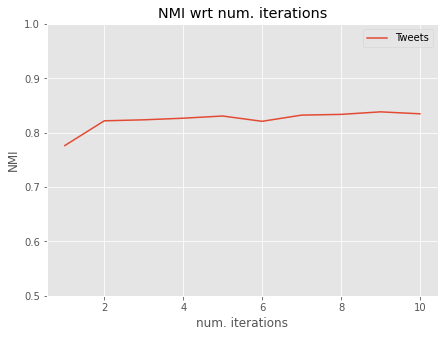

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(7)
ax.set_title("NMI wrt num. iterations")
ax.set_xlabel("num. iterations")
ax.set_ylabel("NMI")
# ax.set_yticks(np.arange(0.5, 1.1, step=0.1))
ax.set_ylim(0.5, 1)
for i, ds_nmi in enumerate(ds_nmis):
    ax.plot(num_iters, ds_nmi, label=DS_NAMES[i])
ax.legend()

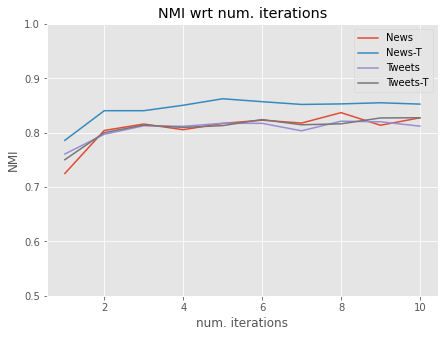

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(7)
ax.set_title("NMI wrt num. iterations")
ax.set_xlabel("num. iterations")
ax.set_ylabel("NMI")
# ax.set_yticks(np.arange(0.5, 1.1, step=0.1))
ax.set_ylim(0.5, 1)
for i, ds_nmi in enumerate(ds_nmis):
    ax.plot(num_iters, ds_nmi, label=DS_NAMES[i])
ax.legend()